# ocaml-alloc-stats notebook

This notebook allows you to read a ".ctf" common trace format file containing a memtrace trace
of allocations from which you can plot some histograms, and perform some simple statistical analysis.

Sample ctf files are uploaded to a shared google drive folder here: https://drive.google.com/drive/folders/1ce5LJ7vEgnaPVgtgUeJ23jHG9vp4K50k?usp=share_link

In the cell below you can specify the ctf file you wish to work with. The file `irmin-replay.ctf` should be present in the git repo and serves as a good example.


In [1]:
ctf_file = "irmin-replay.ctf"

# The following flag controls whether we discard allocations that don't survive the minor 
# heap. These allocations are almost free, so it usually makes sense to discard them when
# focusing on the behaviour of the major heap allocator. FIXME TODO
ignore_minor_only_allocations = True

debug=False # include debug output?

Check that the ctf and executables are present.

In [2]:
# from https://data36.com/plot-histogram-python-pandas/
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import csv # reading CSV format trace files
import subprocess # for calling ocaml executables
import math 
import os.path
import json
import collections


# check that a file we rely on is present
def file_exists(name):
    return os.path.exists(name)

dump_exe = "./dump_trace.exe"

assert file_exists(dump_exe)
assert file_exists(ctf_file)
print("OK, files are present:", dump_exe, ctf_file)

OK, files are present: ./dump_trace.exe irmin-replay.ctf


Run the executable, store results in a temporary file, and return the name of the temporary file. An alternative would be to read the .ctf directly in Python, but according to 
https://babeltrace.org/docs/v2.0/python/bt2/ the Python API is undocumented (although 
probably not too hard to figure out if the current approach is deemed too ugly).

In [3]:
def convert_ctf_to_dump(filename):
    # translate to lookahead format
    outfile1 = filename+".dump"
    subprocess.run([dump_exe,ctf_file,outfile1],check=True)
    return outfile1

the_ctf_dump = convert_ctf_to_dump(ctf_file)

print("NOTE converted ctf placed in file "+the_ctf_dump)

NOTE converted ctf placed in file irmin-replay.ctf.dump


In [4]:
# now we can read the dumped file as plain csv

if ignore_minor_only_allocations: 
    if debug: print("NOTE we are ignoring minor-only allocations")
else: 
    if debug: print("NOTE we are including minor-only allocations")

# read dump, retain all info, return as list
def read_dump(fn):
    xs = []
    with open(fn) as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        for row in reader:
            id = row[1]
            entry_type = row[2]
            assert (entry_type in ["A","a","AE","P","C"])
            entry = {}
            if entry_type in ["A","a","AE"]:
                sz = int(row[3])
                entry={'id':id,'type':entry_type,'sz':sz}
            else: entry={'id':id,'type':entry_type}
            xs.append(entry)
    return xs

the_raw_trace = read_dump(the_ctf_dump)
# print(the_raw_trace[0:10])

assert ignore_minor_only_allocations

# remove allocs that never make it out of the minor heap (they are mostly noise); 
# remove promotes; keep collects for major allocs
def remove_minor_allocs(trace):
    res = [] # result trace
    in_minor = {} # dict of (id -> size) of allocs currently in the minor heap
    for x in trace:
        id = x['id']
        if x['type'] == "a":
            in_minor[id] = x['sz']
        if x['type'] == "A" or x['type'] == "AE":
            res.append(x)
        if x['type'] == "C":
            if id in in_minor.keys(): pass # drop event
            else: res.append(x) # otherwise add to result                
        if x['type'] == "P":
            sz = in_minor[id]
            # convert to a major alloc at time of promote            
            del in_minor[id]
            res.append({'id':id,'type':"A",'sz':sz})
    return res
        
the_trace = remove_minor_allocs(the_raw_trace)

# from this point, we only need alloc sizes so we can drop ids and collect events
the_trace = [ x['sz'] for x in the_trace if x['type']== "A" or x['type'] == "AE"]

# print(the_trace[0:10])
print("Read",len(the_trace),"events")

Read 739 events


In [5]:
def group_allocs_by_size(list_of_allocs):
    # maintain a dict, mapping allocation size to number of allocs
    allocs = dict()
    # and a simple list of alloc sizes
    for sz in list_of_allocs:
        if sz in allocs:
            allocs[sz] = allocs[sz]+1
        else:
            allocs[sz] = 1
    # convert to OrderedDict for readability
    allocs = collections.OrderedDict(sorted(allocs.items()))
    return allocs

the_allocs_by_size = group_allocs_by_size(the_trace)

# for easy debugging, we write the_allocs_by_size to a file
with open("tmp.json","w") as tmp_json:
    json.dump(the_allocs_by_size,tmp_json)
    print("NOTE wrote the_allocs_by_size to tmp.json")

if debug: the_allocs_by_size

NOTE wrote the_allocs_by_size to tmp.json


# Histogram test code

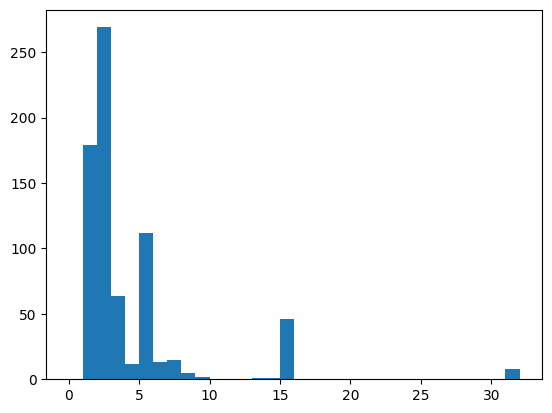

In [6]:
# see https://www.tutorialspoint.com/numpy/numpy_histogram_using_matplotlib.htm
# and https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
_ = plt.hist(np.array(the_trace),range=(0,32),bins=32) 

In [7]:
sorted(list(the_allocs_by_size.items())) # debug

[(1, 179),
 (2, 269),
 (3, 64),
 (4, 12),
 (5, 112),
 (6, 13),
 (7, 15),
 (8, 5),
 (9, 2),
 (13, 1),
 (14, 1),
 (15, 46),
 (32, 8),
 (380, 1),
 (677, 1),
 (923, 1),
 (1145, 1),
 (1379, 1),
 (1751, 1),
 (2116, 1),
 (6250, 1),
 (8193, 1),
 (18401, 1),
 (125004, 1),
 (376181, 1)]

## Histograms

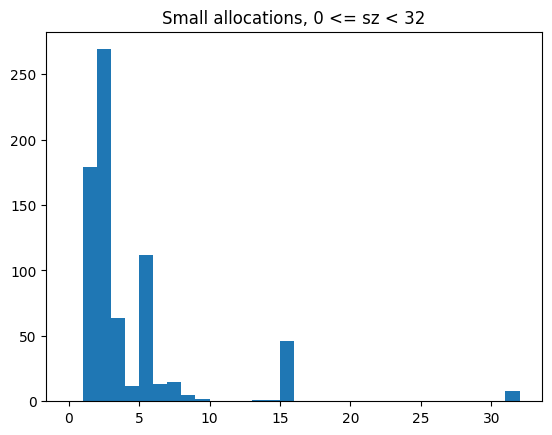

In [8]:
plt.hist(np.array(the_trace),range=(0,32),bins=32) 
_ = plt.title("Small allocations, 0 <= sz < 32")

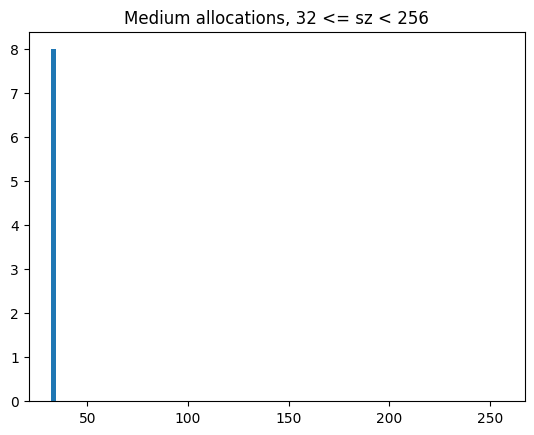

In [9]:
plt.hist(np.array(the_trace),range=(32,256),bins=100) 
_ = plt.title("Medium allocations, 32 <= sz < 256")

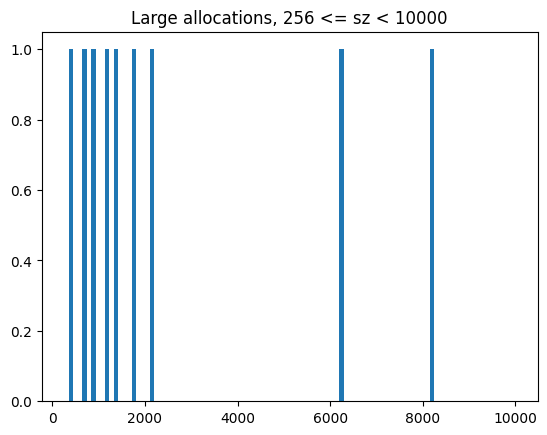

In [10]:
plt.hist(np.array(the_trace),range=(256,10000),bins=100) 
_ = plt.title("Large allocations, 256 <= sz < 10000")

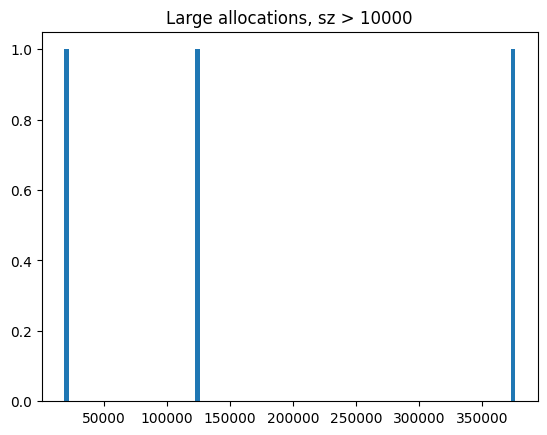

In [11]:
xs = [ x for x in the_trace if x > 10000 ]
plt.hist(np.array(xs),bins=100) 
_ = plt.title("Large allocations, sz > 10000")

# Calculation of some basic statistics

## statistic: percentage of large allocs

In [12]:
# sum allocs.items; split into "small" vs "large" allocs
def compute_ratio_small_large(max_small_sz,allocs):
    def is_small(sz): return sz <= max_small_sz
    total_small_allocs = sum([ v for (k,v) in allocs.items() if is_small(k) ])
    total_large_allocs = sum([ v for (k,v) in allocs.items() if not is_small(k) ])
    percentage_large = 100.0 * total_large_allocs / (total_small_allocs+total_large_allocs)
    total = total_small_allocs+total_large_allocs
    return { "total_small_allocs":total_small_allocs,
            "total_large_allocs": total_large_allocs,
            "total":total,
           "percentage_large": percentage_large}

x = compute_ratio_small_large(256,the_allocs_by_size)

print("Percentage large allocs of total: ", x["percentage_large"] , "(total is "+str(x["total"])+")")



Percentage large allocs of total:  1.6238159675236807 (total is 739)


## statistic: mean, variance, standard deviation, max

We calculate the mean and standard deviation for allocs grouped by size.


In [13]:
# allocs_grouped_by_size should be a map from sz -> count, where count is
# the number of allocations of the given size
def compute_stats(allocs):
    total_count = sum([count_sz for (sz,count_sz) in allocs.items()])
    mean = sum([ sz*count_sz for (sz,count_sz) in allocs.items()]) / total_count
    variance = sum( [count_sz * (sz - mean)**2 for (sz,count_sz) in allocs.items()] ) / total_count
    standard_deviation = math.sqrt(variance) # NOTE sample standard deviation
    max_ = max([ sz for (sz,_) in allocs.items()])
    return { "total_count":total_count, 
           "mean":mean,
           "variance":variance,
            "standard_deviation": standard_deviation,
           "max":max_}
    
def test():
    # https://en.wikipedia.org/wiki/Standard_deviation
    xs = { 2:1, 4:3, 5:2, 7:1, 9:1 }
    stats = compute_stats(xs)
    expected = {'total_count': 8, 'mean': 5.0, 'variance': 4.0, 'standard_deviation': 2.0, 'max': 9}
    assert (stats == expected) 
        
test()
    

In [14]:
print(compute_stats(the_allocs_by_size))

{'total_count': 739, 'mean': 737.660351826793, 'variance': 212710479.02266344, 'standard_deviation': 14584.597321238027, 'max': 376181}


# EXPERIMENTAL: Calculation of stats for segments of the trace

We want to check that the stats are roughly similar for different parts of the trace. For example, are the stats for the first half of the trace similar to those of the second? Essentially we are trying to identify if there are points in the trace where the allocation behaviour changes, see e.g. https://en.wikipedia.org/wiki/Change_detection. There are of course many many ways one might try to decide whether there is a change in allocation behaviour. Comparing stats is one very simple approach.

In [15]:
# divide a list of allocations into n parts, and compute statistics for each part
def compute_stats_for_sublists(allocs,n):
    len_part = int(math.ceil(len(allocs)/n))
    parts = [ allocs[i:i+len_part] for i in range(0,len(allocs),len_part) ]
    grouped = [ group_allocs_by_size(part) for part in parts]
    stats = [ compute_stats(group) for group in grouped]
    return stats # array of stats

compute_stats_for_sublists(the_trace,2)
# NOTE standard deviations tend to differ considerably, 
# due to the presence of a single large allocation initially (?)

[{'total_count': 370,
  'mean': 1438.045945945946,
  'variance': 423667797.5303214,
  'standard_deviation': 20583.192112262896,
  'max': 376181},
 {'total_count': 369,
  'mean': 35.37669376693767,
  'variance': 196388.77138093874,
  'standard_deviation': 443.15772743001867,
  'max': 8193}]

In [16]:
zs = compute_stats_for_sublists(the_trace,10)
print("Part size: "+str(zs[0]['total_count'])) # see how large each part is

sds = [ stat['standard_deviation'] for stat in zs]
sds # look at standard deviations
# NOTE the standard deviation seems hugely different in different parts of the trace

Part size: 74


[43433.24405772415,
 14440.09168696193,
 158.9480191457507,
 5.060986717976299,
 2132.331943132892,
 244.0202320103543,
 131.90353016883486,
 4.778837724038701,
 5.49508379790026,
 951.6948005701006]

In [17]:
# Since the std-devs differ in different parts of the trace, we might like to 
# discard the first n and last m of the trace, and then compute the stats for the parts
# (based on the idea that there is an initial phase, a middle phase, and a final phase).

xs2 = the_trace[100:-100] # drop first and last 100
zs = compute_stats_for_sublists(xs2,2)
sds = [ stat['standard_deviation'] for stat in zs]
sds # look at standard deviations
# NOTE so even with this hack of ignoring the first and last 100 allocs, the allocations 
# in the first half seem different from those in the second. Perhaps irmin-replay does
# allocate differently in the two parts?


[7678.859107909331, 145.93567859933773]

In [18]:
print(xs2) 
# One issue is that "most" of the allocations are small, presumably short lived.
# Then the std-dev is really moved by some rare large allocations.

[2, 2, 1, 1, 3, 1, 125004, 5, 5, 1, 380, 3, 1, 1, 4, 2, 1, 1, 5, 2, 1, 6, 1, 2, 13, 2, 2, 9, 5, 2, 2, 7, 6250, 3, 1, 1, 1, 2, 1, 2, 1, 9, 1, 3, 2, 2, 3, 2, 1, 1, 1, 2, 1, 5, 2, 1, 6, 5, 2, 1, 2, 1, 3, 2, 5, 3, 1, 1, 2, 5, 2, 2, 2, 1, 2, 7, 2, 1, 2, 3, 1, 1, 2, 3, 2, 1, 5, 1, 3, 2, 2, 1, 2, 2, 5, 2, 2, 2, 5, 2, 2, 2, 6, 1, 2, 2, 5, 5, 3, 3, 1, 2, 1, 1, 1, 1379, 1, 6, 5, 1, 2, 1, 2, 1, 32, 2, 3, 1, 32, 5, 1, 2, 1, 1, 1, 6, 1, 1, 2, 6, 1, 2, 1, 3, 1, 2, 2, 3, 1, 5, 3, 1, 5, 1, 2, 2, 2, 4, 2, 7, 2, 5, 1, 4, 5, 1, 5, 1, 1, 7, 5, 5, 3, 1, 7, 1, 2, 2, 3, 2, 2, 2, 1, 2, 2, 1, 5, 5, 2, 2, 2, 3, 1, 2, 2, 3, 4, 2, 2, 2, 1, 2, 1, 5, 2, 2, 1, 2, 923, 5, 2, 2, 2, 1, 2, 7, 2, 2, 3, 2, 2, 2, 1, 677, 2, 3, 2, 2, 32, 5, 2, 1, 2, 5, 1, 1, 2, 1, 1751, 1, 5, 2, 3, 1, 1, 2, 4, 5, 1, 1, 1, 5, 2, 1, 2, 18401, 3, 1, 3, 2, 3, 2, 2, 1, 5, 3, 5, 1, 2, 2, 7, 1, 3, 6, 2, 1, 3, 3, 2116, 2, 3, 1, 2, 1, 3, 2, 2, 1, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 5, 5, 2, 5, 5, 5, 3, 1, 1, 5, 7, 2, 1, 2, 5, 1, 2, 2, 3, 3, 2, 3,

In [19]:
xs3 = [ alloc for alloc in xs2 if alloc > 256] # allocs > 256 words
xs3
compute_stats_for_sublists(xs3,2)
# NOTE still huge difference between sd in first half and second

[{'total_count': 5,
  'mean': 26787.2,
  'variance': 2416038013.3599997,
  'standard_deviation': 49153.2095936776,
  'max': 125004},
 {'total_count': 5,
  'mean': 4818.0,
  'variance': 46368798.4,
  'standard_deviation': 6809.463884917814,
  'max': 18401}]

In [20]:
# One thing we could do is count the number of "large" allocs in each part of the trace
# allocs is a list of allocation sizes; n is the number of parts 
# NOTE this ignores the actual size of each large allocation, and similarly treats all
# small allocations as equals
def count_large_allocs(allocs,n):
    len_part = int(math.ceil(len(allocs)/n))
    parts = [ allocs[i:i+len_part] for i in range(0,len(allocs),len_part) ]
    counts = [ len([x for x in part if x > 256]) for part in parts]
    return counts

count_large_allocs(the_trace,10)
# irmin-replay.ctf, parts = 10: [1, 3, 1, 0, 4, 1, 1, 0, 0, 1]
# It tells us something (5th part of trace has 4 large allocations!), but it would be nice
# to have a 2-phase trace, where allocation behaviour changed, and see if this approach 
# gives us a sensible signal
    

[1, 3, 1, 0, 4, 1, 1, 0, 0, 1]